In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import ParameterGrid
from models import MRIResNetClassifier, DenseNetClassifier, Weights
from multiprocessing import cpu_count

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

train_data_full = datasets.ImageFolder(root="cleaned/Training", transform=transform)
class_names = train_data_full.classes

train_size = int(0.8 * len(train_data_full))  # 80% za trening
val_size = len(train_data_full) - train_size  # 20% za validaciju

train_data, val_data = random_split(train_data_full, [train_size, val_size])
test_data = datasets.ImageFolder(root="cleaned/Testing", transform=transform)

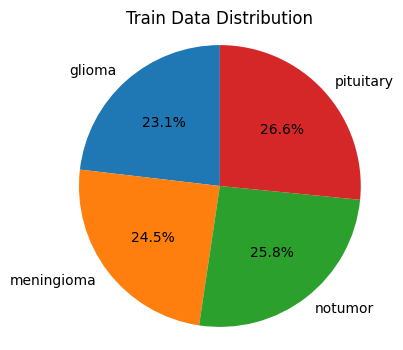

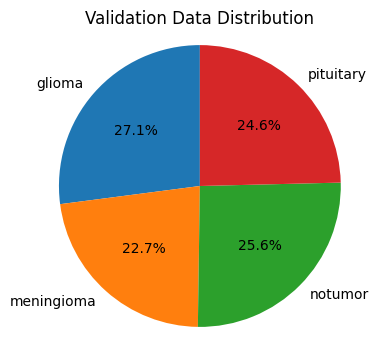

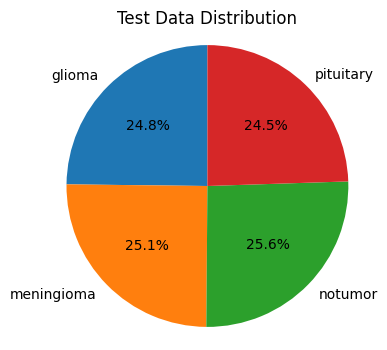

In [4]:
def plot_class_distribution(data, title):
    counts = Counter(data.targets if hasattr(data, 'targets') else [x[1] for x in data])
    labels = [class_names[i] for i in range(len(class_names))]
    plt.figure(figsize=(4, 4))
    plt.pie([counts[i] for i in range(len(class_names))], labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')
    plt.show()

plot_class_distribution(train_data, "Train Data Distribution")
plot_class_distribution(val_data, "Validation Data Distribution")
plot_class_distribution(test_data, "Test Data Distribution")

In [5]:
train_targets = [train_data_full[i][1] for i in train_data.indices]
val_targets = [train_data_full[i][1] for i in val_data.indices]
test_targets = [label for _, label in test_data] 

def count_classes(targets, num_classes):
    counts = [0] * num_classes
    for target in targets:
        counts[target] += 1
    return counts

train_counts = count_classes(train_targets, len(class_names))
val_counts = count_classes(val_targets, len(class_names))
test_counts = count_classes(test_targets, len(class_names))


print("Train-Val-Test Split per Class:")
for i, class_name in enumerate(class_names):
    train_count = train_counts[i]
    val_count = val_counts[i]
    test_count = test_counts[i]
    total_count = train_count + val_count + test_count
    
    train_percentage = (train_count / total_count) * 100 if total_count > 0 else 0
    val_percentage = (val_count / total_count) * 100 if total_count > 0 else 0
    test_percentage = (test_count / total_count) * 100 if total_count > 0 else 0
    
    print(f"{class_name}: Train = {train_count} ({train_percentage:.2f}%), "
          f"Val = {val_count} ({val_percentage:.2f}%), "
          f"Test = {test_count} ({test_percentage:.2f}%)")

Train-Val-Test Split per Class:
glioma: Train = 1022 (63.09%), Val = 299 (18.46%), Test = 299 (18.46%)
meningioma: Train = 1082 (66.18%), Val = 251 (15.35%), Test = 302 (18.47%)
notumor: Train = 1139 (65.80%), Val = 283 (16.35%), Test = 309 (17.85%)
pituitary: Train = 1173 (67.41%), Val = 272 (15.63%), Test = 295 (16.95%)


In [6]:
num_workers = cpu_count() // 2

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=num_workers)

In [7]:
def train(model, epochs, train_loader, val_loader, optimizer, criterion, device, save_path="best_model.pth"):
    best_val_acc = 0
    
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        train_pred_correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            train_pred_correct += (outputs.argmax(1) == labels).sum().item()
            total += len(labels)

        train_accuracy = train_pred_correct / total
        train_accuracies.append(train_accuracy)

        model.eval()
        total_val_loss = 0.0
        val_pred_correct = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                val_pred_correct += (outputs.argmax(1) == labels).sum().item()
                total_val += len(labels)

        val_accuracy = val_pred_correct / total_val
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), save_path)

        print(f"Epoch {epoch+1}: Train Loss={total_train_loss/len(train_loader):.4f}, "
              f"Train Acc={train_accuracy:.4f}, Val Loss={total_val_loss/len(val_loader):.4f}, "
              f"Val Acc={val_accuracy:.4f}")
    
    # we load the model with the best val accuracy for later test set evaluation
    model.load_state_dict(torch.load(save_path, weights_only=True))
    os.remove(save_path)
    
    return train_accuracies, val_accuracies, best_val_acc


def evaluate(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            pred_labels = outputs.argmax(dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(pred_labels.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    acc = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="macro")

    print("Confusion matrix:\n", conf_matrix)
    print('Accuracy:', acc)
    print('F1 score:', f1)
    return acc, f1
                

In [8]:
def plot_metrics(epochs, train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='blue', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='red', marker='x')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

Testing parameters: {'batch_size': 64, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0001}
Epoch 1: Train Loss=1.0915, Train Acc=0.7156, Val Loss=0.9765, Val Acc=0.8063
Epoch 2: Train Loss=0.9483, Train Acc=0.8331, Val Loss=0.9279, Val Acc=0.8407
Epoch 3: Train Loss=0.9237, Train Acc=0.8449, Val Loss=0.9079, Val Acc=0.8543
Epoch 4: Train Loss=0.9057, Train Acc=0.8630, Val Loss=0.9003, Val Acc=0.8606
Epoch 5: Train Loss=0.8980, Train Acc=0.8646, Val Loss=0.8902, Val Acc=0.8697
Epoch 6: Train Loss=0.8940, Train Acc=0.8675, Val Loss=0.8790, Val Acc=0.8851
Epoch 7: Train Loss=0.8853, Train Acc=0.8784, Val Loss=0.8838, Val Acc=0.8814
Epoch 8: Train Loss=0.8800, Train Acc=0.8795, Val Loss=0.8785, Val Acc=0.8697
Epoch 9: Train Loss=0.8773, Train Acc=0.8811, Val Loss=0.8722, Val Acc=0.8887
Epoch 10: Train Loss=0.8748, Train Acc=0.8829, Val Loss=0.8622, Val Acc=0.8968
Epoch 11: Train Loss=0.8673, Train Acc=0.8909, Val Loss=0.8680, Val Acc=0.8905
Epoch 12: Train Loss=0.8681, Train Acc=0.8897, V

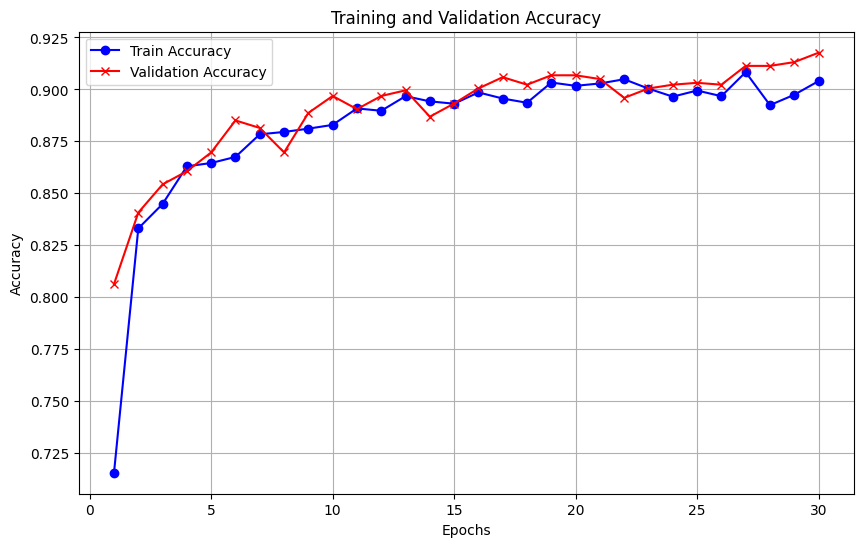

Test evaluation:
Confusion matrix:
 [[242  54   0   3]
 [ 14 239  25  24]
 [  1   3 305   0]
 [  3  18   0 274]]
Accuracy: 0.8796680497925311
F1 score: 0.8789713860544456


(0.8796680497925311, 0.8789713860544456)

In [10]:
# RESNET pretrained ON IMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer

EPOCHS = 30

param_grid = {
    'lr': [0.001, 0.0001],
    'batch_size': [64, 128],
    'weight_decay': [1e-4],
    'dropout': [0.3, 0.5]
}

best_params = None
best_accuracy = 0.0
best_train_accuracies = []
best_val_accuracies = []

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model = MRIResNetClassifier(len(train_data_full.classes), weights=Weights.IMN, dropout=params['dropout'], train_resnet=False).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

    train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

    if best_val_accuracy > best_accuracy:
        best_accuracy = best_val_accuracy
        best_train_accuracies = train_accuracies
        best_val_accuracies = val_accuracies
        best_params = params
        best_model = model

print("Best Hyperparameters:", best_params)

plot_metrics(EPOCHS, best_train_accuracies, best_val_accuracies)

print('Test evaluation:')
evaluate(best_model, test_loader, device)

Testing parameters: {'batch_size': 64, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0001}


/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss=1.2012, Train Acc=0.6150, Val Loss=1.0785, Val Acc=0.7647
Epoch 2: Train Loss=1.0553, Train Acc=0.7536, Val Loss=1.0215, Val Acc=0.7765
Epoch 3: Train Loss=1.0199, Train Acc=0.7711, Val Loss=0.9953, Val Acc=0.7973
Epoch 4: Train Loss=0.9999, Train Acc=0.7822, Val Loss=0.9811, Val Acc=0.8018
Epoch 5: Train Loss=0.9805, Train Acc=0.7933, Val Loss=0.9654, Val Acc=0.8072
Epoch 6: Train Loss=0.9779, Train Acc=0.7914, Val Loss=0.9559, Val Acc=0.8145
Epoch 7: Train Loss=0.9750, Train Acc=0.7937, Val Loss=0.9525, Val Acc=0.8172
Epoch 8: Train Loss=0.9661, Train Acc=0.8019, Val Loss=0.9499, Val Acc=0.8271
Epoch 9: Train Loss=0.9562, Train Acc=0.8066, Val Loss=0.9428, Val Acc=0.8145
Epoch 10: Train Loss=0.9546, Train Acc=0.8105, Val Loss=0.9369, Val Acc=0.8262
Epoch 11: Train Loss=0.9465, Train Acc=0.8173, Val Loss=0.9472, Val Acc=0.8172
Epoch 12: Train Loss=0.9505, Train Acc=0.8109, Val Loss=0.9258, Val Acc=0.8353
Epoch 13: Train Loss=0.9479, Train Acc=0.8173, Val Loss=0.924

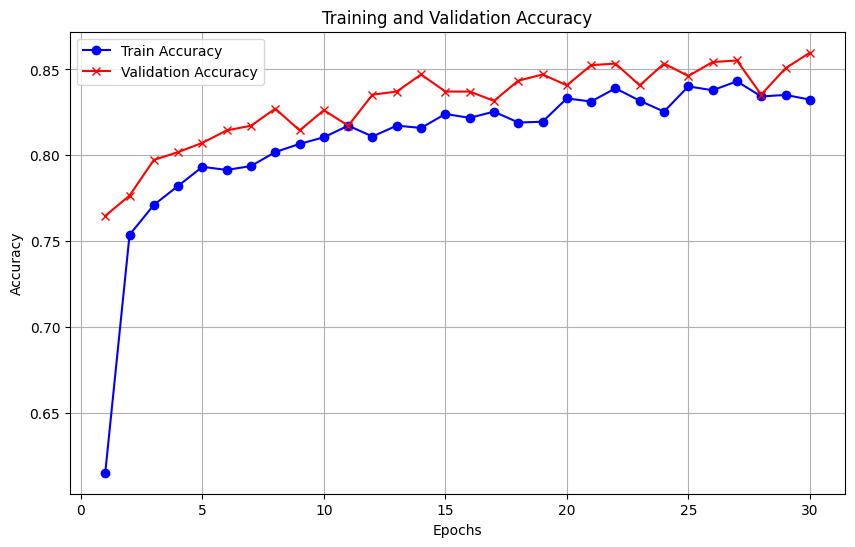

Test evaluation:
Confusion matrix:
 [[218  58   7  16]
 [  9 194  68  31]
 [  3   4 301   1]
 [  4  13   2 276]]
Accuracy: 0.820746887966805
F1 score: 0.8163888618777553


(0.820746887966805, 0.8163888618777553)

In [11]:
# RESNET pretrained ON RADIMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer

EPOCHS = 30

param_grid = {
    'lr': [0.001, 0.0001],
    'batch_size': [64, 128],
    'weight_decay': [1e-4],
    'dropout': [0.3, 0.5]
}

best_params = None
best_accuracy = 0.0
best_train_accuracies = []
best_val_accuracies = []

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model = MRIResNetClassifier(len(train_data_full.classes), weights=Weights.RIMN, dropout=params['dropout'], train_resnet=False).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

    train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

    if best_val_accuracy > best_accuracy:
        best_accuracy = best_val_accuracy
        best_train_accuracies = train_accuracies
        best_val_accuracies = val_accuracies
        best_params = params
        best_model = model

print("Best Hyperparameters:", best_params)

plot_metrics(EPOCHS, best_train_accuracies, best_val_accuracies)

print('Test evaluation:')
evaluate(best_model, test_loader, device)

Testing parameters: {'batch_size': 64, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0001}


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/maritaradic/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 33.3MB/s]


Epoch 1: Train Loss=0.9127, Train Acc=0.8288, Val Loss=0.8769, Val Acc=0.8633
Epoch 2: Train Loss=0.8536, Train Acc=0.8893, Val Loss=0.8397, Val Acc=0.9014
Epoch 3: Train Loss=0.8296, Train Acc=0.9133, Val Loss=0.8587, Val Acc=0.8869
Epoch 4: Train Loss=0.8240, Train Acc=0.9196, Val Loss=0.8434, Val Acc=0.8968
Epoch 5: Train Loss=0.8109, Train Acc=0.9330, Val Loss=0.8422, Val Acc=0.9014
Epoch 6: Train Loss=0.8073, Train Acc=0.9355, Val Loss=0.8452, Val Acc=0.8995
Epoch 7: Train Loss=0.8081, Train Acc=0.9350, Val Loss=0.8364, Val Acc=0.9086
Epoch 8: Train Loss=0.8005, Train Acc=0.9434, Val Loss=0.8237, Val Acc=0.9204
Epoch 9: Train Loss=0.7969, Train Acc=0.9461, Val Loss=0.8294, Val Acc=0.9113
Epoch 10: Train Loss=0.7910, Train Acc=0.9518, Val Loss=0.8284, Val Acc=0.9140
Epoch 11: Train Loss=0.7901, Train Acc=0.9529, Val Loss=0.8383, Val Acc=0.9050
Epoch 12: Train Loss=0.7878, Train Acc=0.9558, Val Loss=0.8315, Val Acc=0.9095
Epoch 13: Train Loss=0.7854, Train Acc=0.9586, Val Loss=0.824

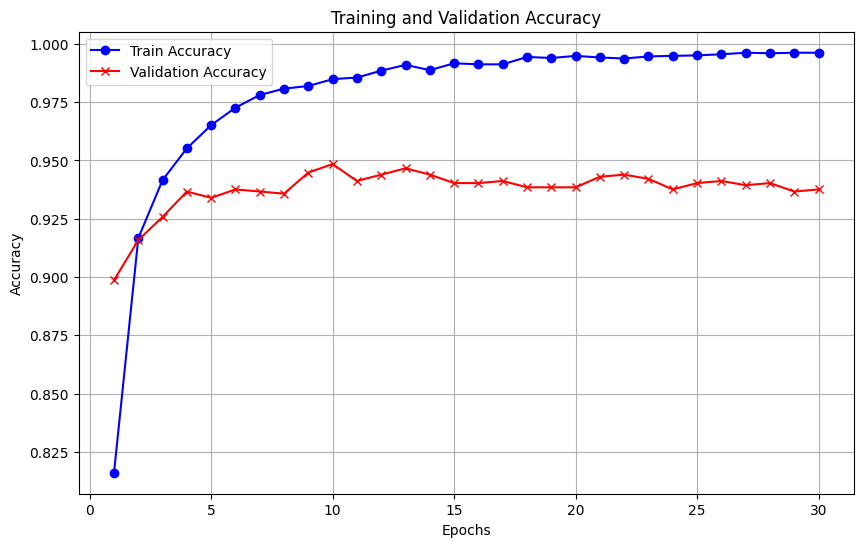

Test evaluation:
Confusion matrix:
 [[260  33   1   5]
 [ 15 270   9   8]
 [  0   3 306   0]
 [  0   5   0 290]]
Accuracy: 0.9344398340248963
F1 score: 0.933984137616737


(0.9344398340248963, 0.933984137616737)

In [13]:
# DENSENET pretrained ON IMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer

EPOCHS = 30

param_grid = {
    'lr': [0.001, 0.0001],
    'batch_size': [64, 128],
    'weight_decay': [1e-4],
    'dropout': [0.3, 0.5]
}

best_params = None
best_accuracy = 0.0
best_train_accuracies = []
best_val_accuracies = []

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model = DenseNetClassifier(len(train_data_full.classes), weights=Weights.IMN, dropout=params['dropout'], train_densenet=False).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

    train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

    if best_val_accuracy > best_accuracy:
        best_accuracy = best_val_accuracy
        best_train_accuracies = train_accuracies
        best_val_accuracies = val_accuracies
        best_params = params
        best_model = model

print("Best Hyperparameters:", best_params)

plot_metrics(EPOCHS, best_train_accuracies, best_val_accuracies)

print('Test evaluation:')
evaluate(best_model, test_loader, device)

Testing parameters: {'batch_size': 64, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0001}


/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss=1.1094, Train Acc=0.7346, Val Loss=1.0042, Val Acc=0.8362
Epoch 2: Train Loss=0.9700, Train Acc=0.8558, Val Loss=0.9502, Val Acc=0.8588
Epoch 3: Train Loss=0.9305, Train Acc=0.8745, Val Loss=0.9132, Val Acc=0.8615
Epoch 4: Train Loss=0.9044, Train Acc=0.8884, Val Loss=0.8986, Val Acc=0.8751
Epoch 5: Train Loss=0.8917, Train Acc=0.8961, Val Loss=0.8914, Val Acc=0.8778
Epoch 6: Train Loss=0.8779, Train Acc=0.9031, Val Loss=0.8800, Val Acc=0.8878
Epoch 7: Train Loss=0.8701, Train Acc=0.9092, Val Loss=0.8903, Val Acc=0.8842
Epoch 8: Train Loss=0.8681, Train Acc=0.9155, Val Loss=0.8811, Val Acc=0.8950
Epoch 9: Train Loss=0.8637, Train Acc=0.9176, Val Loss=0.8734, Val Acc=0.8932
Epoch 10: Train Loss=0.8550, Train Acc=0.9230, Val Loss=0.8765, Val Acc=0.8986
Epoch 11: Train Loss=0.8508, Train Acc=0.9287, Val Loss=0.8632, Val Acc=0.9041
Epoch 12: Train Loss=0.8470, Train Acc=0.9314, Val Loss=0.8671, Val Acc=0.9023
Epoch 13: Train Loss=0.8445, Train Acc=0.9321, Val Loss=0.865

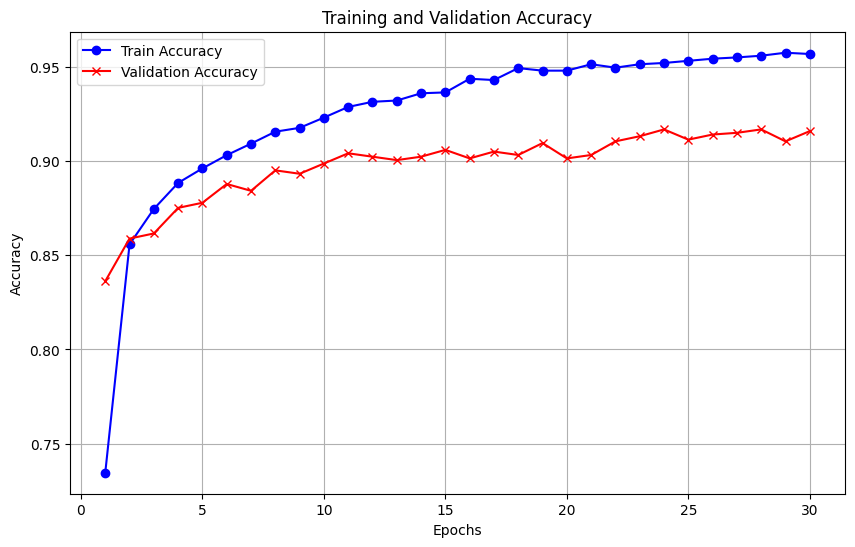

Test evaluation:
Confusion matrix:
 [[250  39   2   8]
 [ 11 256  19  16]
 [  2   7 300   0]
 [  4   8   1 282]]
Accuracy: 0.9029045643153527
F1 score: 0.9023252764418555


(0.9029045643153527, 0.9023252764418555)

In [12]:
# DENSENET pretrained ON RADIMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer

EPOCHS = 30

param_grid = {
    'lr': [0.001, 0.0001],
    'batch_size': [64, 128],
    'weight_decay': [1e-4],
    'dropout': [0.3, 0.5]
}

best_params = None
best_accuracy = 0.0
best_train_accuracies = []
best_val_accuracies = []

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model = DenseNetClassifier(len(train_data_full.classes), weights=Weights.RIMN, dropout=params['dropout'], train_densenet=False).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

    train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

    if best_val_accuracy > best_accuracy:
        best_accuracy = best_val_accuracy
        best_train_accuracies = train_accuracies
        best_val_accuracies = val_accuracies
        best_params = params
        best_model = model

print("Best Hyperparameters:", best_params)

plot_metrics(EPOCHS, best_train_accuracies, best_val_accuracies)

print('Test evaluation:')
evaluate(best_model, test_loader, device)

Na temelju rezultata treniranja zaključujemo da ima smisla najbolje mreže ostaviti da se duže treniraju te isprobati treniranje bez primjene dropout sloja.

Epoch 1: Train Loss=1.0872, Train Acc=0.7260, Val Loss=0.9622, Val Acc=0.8253
Epoch 2: Train Loss=0.9440, Train Acc=0.8435, Val Loss=0.9243, Val Acc=0.8471
Epoch 3: Train Loss=0.9196, Train Acc=0.8537, Val Loss=0.9029, Val Acc=0.8615
Epoch 4: Train Loss=0.9058, Train Acc=0.8635, Val Loss=0.9028, Val Acc=0.8652
Epoch 5: Train Loss=0.8975, Train Acc=0.8666, Val Loss=0.8833, Val Acc=0.8805
Epoch 6: Train Loss=0.8948, Train Acc=0.8693, Val Loss=0.8895, Val Acc=0.8769
Epoch 7: Train Loss=0.8805, Train Acc=0.8800, Val Loss=0.8721, Val Acc=0.8814
Epoch 8: Train Loss=0.8791, Train Acc=0.8804, Val Loss=0.8693, Val Acc=0.8860
Epoch 9: Train Loss=0.8732, Train Acc=0.8863, Val Loss=0.8728, Val Acc=0.8796
Epoch 10: Train Loss=0.8685, Train Acc=0.8913, Val Loss=0.8688, Val Acc=0.8833
Epoch 11: Train Loss=0.8675, Train Acc=0.8911, Val Loss=0.8616, Val Acc=0.8995
Epoch 12: Train Loss=0.8689, Train Acc=0.8872, Val Loss=0.8662, Val Acc=0.8851
Epoch 13: Train Loss=0.8665, Train Acc=0.8915, Val Loss=0.861

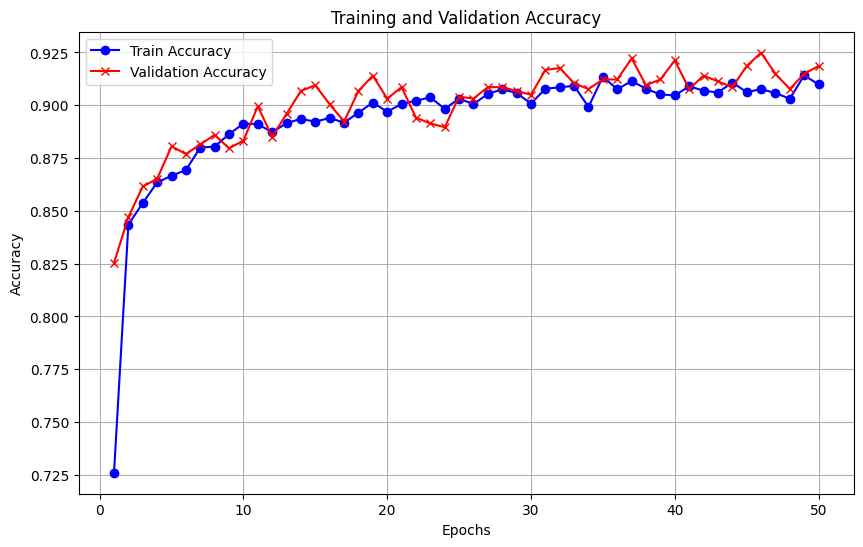

Test evaluation:
Confusion matrix:
 [[250  45   1   3]
 [ 15 236  29  22]
 [  1   1 307   0]
 [  6  12   0 277]]
Accuracy: 0.8879668049792531
F1 score: 0.8865101617241408


(0.8879668049792531, 0.8865101617241408)

In [22]:
# RESNET pretrained ON IMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer
# BEST MODEL WITH 0.3 DROPOUT

EPOCHS = 50

model = MRIResNetClassifier(len(train_data_full.classes), weights=Weights.IMN, dropout=0.3, train_resnet=False).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

plot_metrics(EPOCHS, train_accuracies, val_accuracies)

print('Test evaluation:')
evaluate(model, test_loader, device)

Epoch 1: Train Loss=1.0768, Train Acc=0.7319, Val Loss=0.9623, Val Acc=0.8181
Epoch 2: Train Loss=0.9372, Train Acc=0.8485, Val Loss=0.9218, Val Acc=0.8561
Epoch 3: Train Loss=0.9155, Train Acc=0.8571, Val Loss=0.9074, Val Acc=0.8633
Epoch 4: Train Loss=0.8973, Train Acc=0.8723, Val Loss=0.8937, Val Acc=0.8679
Epoch 5: Train Loss=0.8904, Train Acc=0.8743, Val Loss=0.8816, Val Acc=0.8851
Epoch 6: Train Loss=0.8769, Train Acc=0.8899, Val Loss=0.8774, Val Acc=0.8896
Epoch 7: Train Loss=0.8762, Train Acc=0.8852, Val Loss=0.8716, Val Acc=0.8932
Epoch 8: Train Loss=0.8666, Train Acc=0.8963, Val Loss=0.8685, Val Acc=0.8932
Epoch 9: Train Loss=0.8612, Train Acc=0.9017, Val Loss=0.8616, Val Acc=0.8986
Epoch 10: Train Loss=0.8564, Train Acc=0.9042, Val Loss=0.8620, Val Acc=0.8986
Epoch 11: Train Loss=0.8605, Train Acc=0.8979, Val Loss=0.8698, Val Acc=0.8814
Epoch 12: Train Loss=0.8502, Train Acc=0.9101, Val Loss=0.8564, Val Acc=0.9041
Epoch 13: Train Loss=0.8436, Train Acc=0.9176, Val Loss=0.853

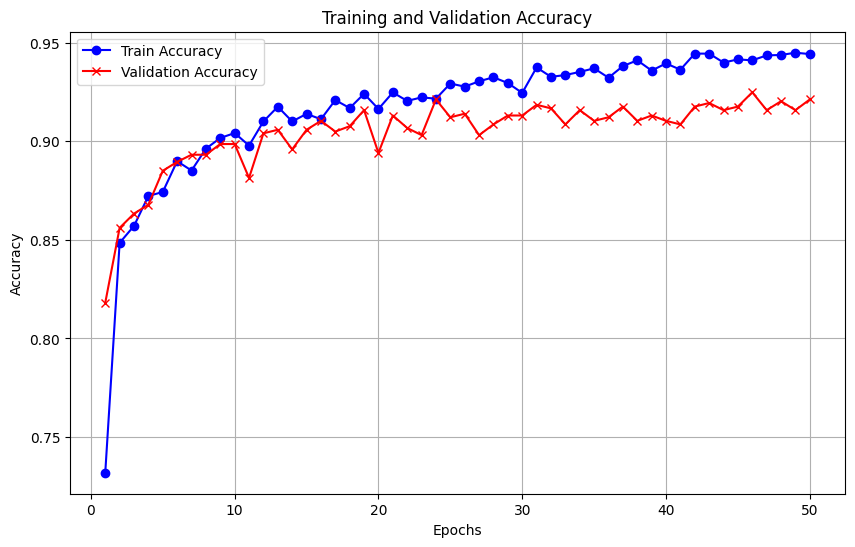

Test evaluation:
Confusion matrix:
 [[252  45   1   1]
 [ 18 247  21  16]
 [  1   2 306   0]
 [  6  15   1 273]]
Accuracy: 0.8946058091286307
F1 score: 0.8940229051335068


(0.8946058091286307, 0.8940229051335068)

In [24]:
# RESNET pretrained ON IMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer
# BEST MODEL WITHOUT DROPOUT

EPOCHS = 50

model = MRIResNetClassifier(len(train_data_full.classes), weights=Weights.IMN, dropout=0, train_resnet=False).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

plot_metrics(EPOCHS, train_accuracies, val_accuracies)

print('Test evaluation:')
evaluate(model, test_loader, device)

/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss=1.2085, Train Acc=0.5969, Val Loss=1.1192, Val Acc=0.6715
Epoch 2: Train Loss=1.0689, Train Acc=0.7262, Val Loss=1.0264, Val Acc=0.7683
Epoch 3: Train Loss=1.0240, Train Acc=0.7722, Val Loss=0.9930, Val Acc=0.7973
Epoch 4: Train Loss=1.0059, Train Acc=0.7720, Val Loss=0.9839, Val Acc=0.7991
Epoch 5: Train Loss=0.9923, Train Acc=0.7862, Val Loss=0.9729, Val Acc=0.8109
Epoch 6: Train Loss=0.9845, Train Acc=0.7822, Val Loss=0.9653, Val Acc=0.8018
Epoch 7: Train Loss=0.9743, Train Acc=0.7955, Val Loss=0.9601, Val Acc=0.8109
Epoch 8: Train Loss=0.9640, Train Acc=0.8059, Val Loss=0.9464, Val Acc=0.8217
Epoch 9: Train Loss=0.9610, Train Acc=0.8066, Val Loss=0.9496, Val Acc=0.8081
Epoch 10: Train Loss=0.9534, Train Acc=0.8091, Val Loss=0.9399, Val Acc=0.8217
Epoch 11: Train Loss=0.9536, Train Acc=0.8055, Val Loss=0.9356, Val Acc=0.8217
Epoch 12: Train Loss=0.9464, Train Acc=0.8163, Val Loss=0.9443, Val Acc=0.8145
Epoch 13: Train Loss=0.9487, Train Acc=0.8136, Val Loss=0.938

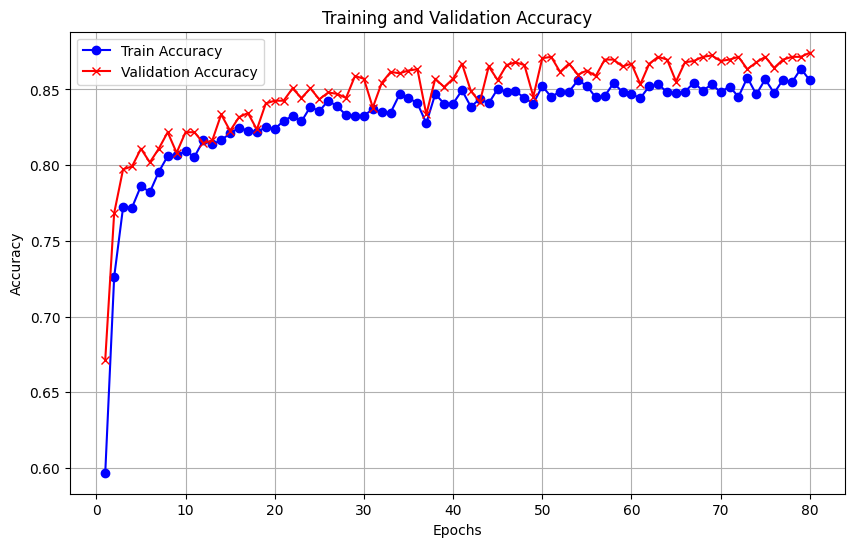

Test evaluation:
Confusion matrix:
 [[241  46   2  10]
 [ 16 212  49  25]
 [  3   3 303   0]
 [ 10  14   2 269]]
Accuracy: 0.8506224066390041
F1 score: 0.8478443331329062


(0.8506224066390041, 0.8478443331329062)

In [25]:
# RESNET pretrained ON RADIMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer
# BEST MODEL WITH 0.3 DROPOUT

EPOCHS = 80

model = MRIResNetClassifier(len(train_data_full.classes), weights=Weights.RIMN, dropout=0.3, train_resnet=False).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

plot_metrics(EPOCHS, train_accuracies, val_accuracies)

print('Test evaluation:')
evaluate(model, test_loader, device)

/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss=1.1826, Train Acc=0.6293, Val Loss=1.0617, Val Acc=0.7584
Epoch 2: Train Loss=1.0487, Train Acc=0.7579, Val Loss=1.0141, Val Acc=0.7900
Epoch 3: Train Loss=1.0051, Train Acc=0.7837, Val Loss=0.9921, Val Acc=0.7955
Epoch 4: Train Loss=0.9874, Train Acc=0.8019, Val Loss=0.9732, Val Acc=0.8000
Epoch 5: Train Loss=0.9761, Train Acc=0.8007, Val Loss=0.9571, Val Acc=0.8226
Epoch 6: Train Loss=0.9637, Train Acc=0.8123, Val Loss=0.9603, Val Acc=0.8090
Epoch 7: Train Loss=0.9540, Train Acc=0.8166, Val Loss=0.9461, Val Acc=0.8253
Epoch 8: Train Loss=0.9466, Train Acc=0.8243, Val Loss=0.9382, Val Acc=0.8217
Epoch 9: Train Loss=0.9501, Train Acc=0.8177, Val Loss=0.9653, Val Acc=0.7828
Epoch 10: Train Loss=0.9394, Train Acc=0.8254, Val Loss=0.9300, Val Acc=0.8253
Epoch 11: Train Loss=0.9310, Train Acc=0.8338, Val Loss=0.9242, Val Acc=0.8344
Epoch 12: Train Loss=0.9285, Train Acc=0.8358, Val Loss=0.9304, Val Acc=0.8389
Epoch 13: Train Loss=0.9242, Train Acc=0.8444, Val Loss=0.921

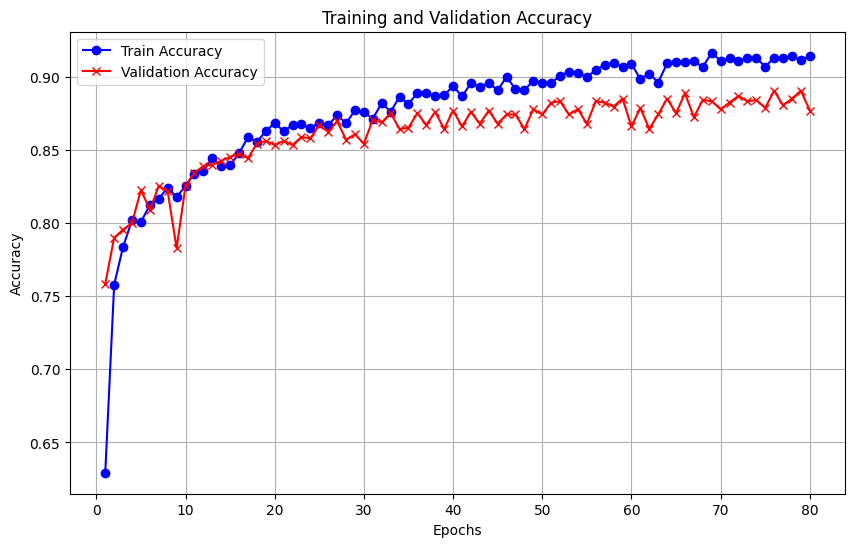

Test evaluation:
Confusion matrix:
 [[238  50   1  10]
 [  7 251  22  22]
 [  0   8 301   0]
 [  2   8   1 284]]
Accuracy: 0.891286307053942
F1 score: 0.8904826785041177


(0.891286307053942, 0.8904826785041177)

In [26]:
# RESNET pretrained ON RADIMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer
# BEST MODEL WITHOUT DROPOUT

EPOCHS = 80

model = MRIResNetClassifier(len(train_data_full.classes), weights=Weights.RIMN, dropout=0, train_resnet=False).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

plot_metrics(EPOCHS, train_accuracies, val_accuracies)

print('Test evaluation:')
evaluate(model, test_loader, device)

Epoch 1: Train Loss=0.9231, Train Acc=0.8313, Val Loss=0.8455, Val Acc=0.9077
Epoch 2: Train Loss=0.8257, Train Acc=0.9266, Val Loss=0.8295, Val Acc=0.9213
Epoch 3: Train Loss=0.8000, Train Acc=0.9497, Val Loss=0.8257, Val Acc=0.9249
Epoch 4: Train Loss=0.7859, Train Acc=0.9660, Val Loss=0.8197, Val Acc=0.9339
Epoch 5: Train Loss=0.7728, Train Acc=0.9780, Val Loss=0.8163, Val Acc=0.9376
Epoch 6: Train Loss=0.7665, Train Acc=0.9835, Val Loss=0.8099, Val Acc=0.9439
Epoch 7: Train Loss=0.7642, Train Acc=0.9841, Val Loss=0.8104, Val Acc=0.9412
Epoch 8: Train Loss=0.7606, Train Acc=0.9885, Val Loss=0.8090, Val Acc=0.9430
Epoch 9: Train Loss=0.7579, Train Acc=0.9898, Val Loss=0.8119, Val Acc=0.9357
Epoch 10: Train Loss=0.7558, Train Acc=0.9921, Val Loss=0.8090, Val Acc=0.9412
Epoch 11: Train Loss=0.7548, Train Acc=0.9925, Val Loss=0.8106, Val Acc=0.9376
Epoch 12: Train Loss=0.7530, Train Acc=0.9941, Val Loss=0.8058, Val Acc=0.9457
Epoch 13: Train Loss=0.7528, Train Acc=0.9932, Val Loss=0.807

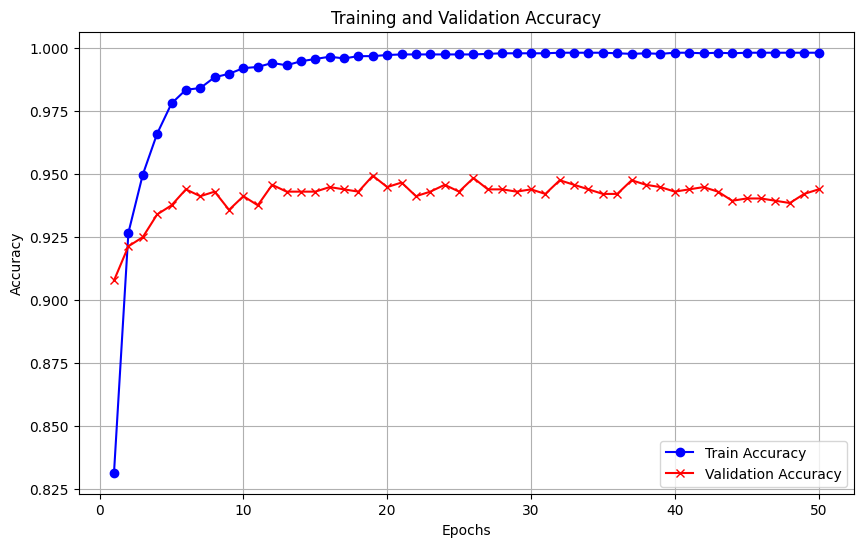

Test evaluation:
Confusion matrix:
 [[273  18   0   8]
 [  9 277   7   9]
 [  0   0 309   0]
 [  2   5   1 287]]
Accuracy: 0.9510373443983402
F1 score: 0.9505712909801061


(0.9510373443983402, 0.9505712909801061)

In [27]:
# DENSENET pretrained ON IMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer
# BEST MODEL WITH 0.3 DROPOUT

EPOCHS = 50

model = DenseNetClassifier(len(train_data_full.classes), weights=Weights.IMN, dropout=0.3, train_densenet=False).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

plot_metrics(EPOCHS, train_accuracies, val_accuracies)

print('Test evaluation:')
evaluate(model, test_loader, device)

Epoch 1: Train Loss=0.9223, Train Acc=0.8293, Val Loss=0.8542, Val Acc=0.8959
Epoch 2: Train Loss=0.8197, Train Acc=0.9321, Val Loss=0.8288, Val Acc=0.9240
Epoch 3: Train Loss=0.7920, Train Acc=0.9590, Val Loss=0.8176, Val Acc=0.9357
Epoch 4: Train Loss=0.7774, Train Acc=0.9735, Val Loss=0.8157, Val Acc=0.9403
Epoch 5: Train Loss=0.7664, Train Acc=0.9837, Val Loss=0.8164, Val Acc=0.9312
Epoch 6: Train Loss=0.7620, Train Acc=0.9860, Val Loss=0.8119, Val Acc=0.9412
Epoch 7: Train Loss=0.7583, Train Acc=0.9891, Val Loss=0.8142, Val Acc=0.9376
Epoch 8: Train Loss=0.7552, Train Acc=0.9923, Val Loss=0.8155, Val Acc=0.9339
Epoch 9: Train Loss=0.7532, Train Acc=0.9934, Val Loss=0.8104, Val Acc=0.9403
Epoch 10: Train Loss=0.7516, Train Acc=0.9943, Val Loss=0.8095, Val Acc=0.9357
Epoch 11: Train Loss=0.7503, Train Acc=0.9957, Val Loss=0.8104, Val Acc=0.9394
Epoch 12: Train Loss=0.7500, Train Acc=0.9957, Val Loss=0.8072, Val Acc=0.9439
Epoch 13: Train Loss=0.7488, Train Acc=0.9964, Val Loss=0.806

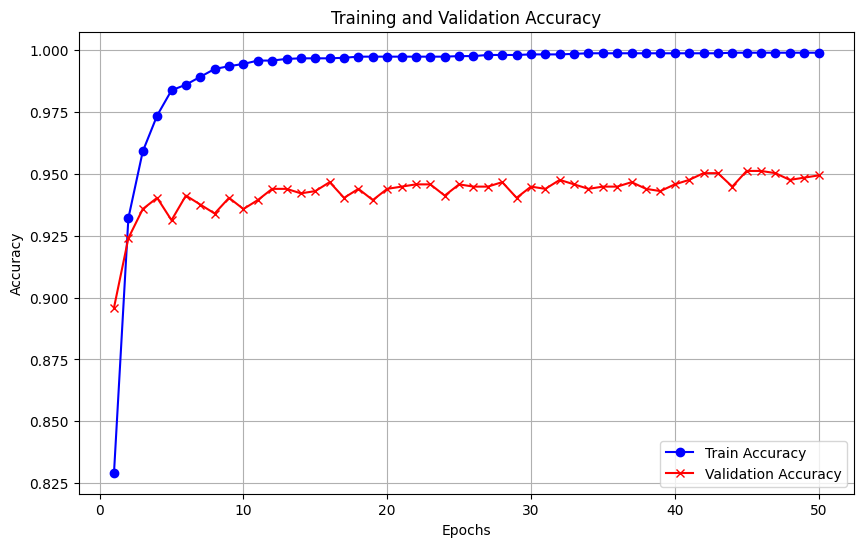

Test evaluation:
Confusion matrix:
 [[267  26   0   6]
 [  9 280   5   8]
 [  0   0 309   0]
 [  1   5   1 288]]
Accuracy: 0.9493775933609958
F1 score: 0.948958009173634


(0.9493775933609958, 0.948958009173634)

In [28]:
# DENSENET pretrained ON IMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer
# BEST MODEL WITHOUT DROPOUT

EPOCHS = 50

model = DenseNetClassifier(len(train_data_full.classes), weights=Weights.IMN, dropout=0, train_densenet=False).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

plot_metrics(EPOCHS, train_accuracies, val_accuracies)

print('Test evaluation:')
evaluate(model, test_loader, device)

/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss=1.1166, Train Acc=0.7797, Val Loss=1.0132, Val Acc=0.8326
Epoch 2: Train Loss=0.9672, Train Acc=0.8510, Val Loss=0.9423, Val Acc=0.8561
Epoch 3: Train Loss=0.9279, Train Acc=0.8757, Val Loss=0.9266, Val Acc=0.8652
Epoch 4: Train Loss=0.9121, Train Acc=0.8850, Val Loss=0.9025, Val Acc=0.8751
Epoch 5: Train Loss=0.8987, Train Acc=0.8958, Val Loss=0.8989, Val Acc=0.8769
Epoch 6: Train Loss=0.8763, Train Acc=0.9074, Val Loss=0.8685, Val Acc=0.8896
Epoch 7: Train Loss=0.8741, Train Acc=0.9085, Val Loss=0.8800, Val Acc=0.8914
Epoch 8: Train Loss=0.8665, Train Acc=0.9137, Val Loss=0.8709, Val Acc=0.8941
Epoch 9: Train Loss=0.8640, Train Acc=0.9192, Val Loss=0.8690, Val Acc=0.8986
Epoch 10: Train Loss=0.8535, Train Acc=0.9230, Val Loss=0.8639, Val Acc=0.9014
Epoch 11: Train Loss=0.8484, Train Acc=0.9287, Val Loss=0.8623, Val Acc=0.9014
Epoch 12: Train Loss=0.8456, Train Acc=0.9321, Val Loss=0.8585, Val Acc=0.8986
Epoch 13: Train Loss=0.8448, Train Acc=0.9305, Val Loss=0.863

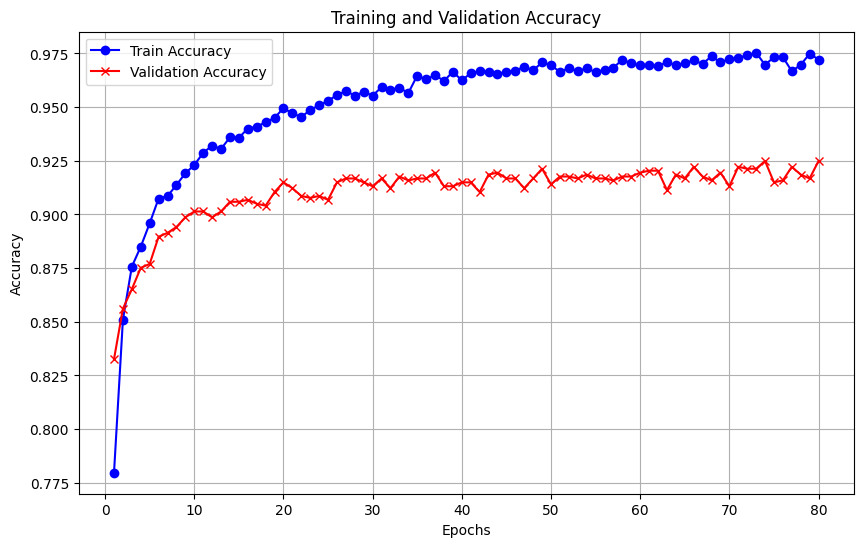

Test evaluation:
Confusion matrix:
 [[251  44   2   2]
 [  8 270  10  14]
 [  2   4 303   0]
 [  3  14   0 278]]
Accuracy: 0.9145228215767635
F1 score: 0.9146283905624224


(0.9145228215767635, 0.9146283905624224)

In [29]:
# DENSENET pretrained ON RADIMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer
# BEST MODEL WITH 0.3 DROPOUT

EPOCHS = 80

model = DenseNetClassifier(len(train_data_full.classes), weights=Weights.RIMN, dropout=0.3, train_densenet=False).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

plot_metrics(EPOCHS, train_accuracies, val_accuracies)

print('Test evaluation:')
evaluate(model, test_loader, device)

/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maritaradic/GIT/brain-tumor-classification/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss=1.1034, Train Acc=0.7495, Val Loss=0.9780, Val Acc=0.8253
Epoch 2: Train Loss=0.9572, Train Acc=0.8537, Val Loss=0.9435, Val Acc=0.8597
Epoch 3: Train Loss=0.9128, Train Acc=0.8804, Val Loss=0.9117, Val Acc=0.8661
Epoch 4: Train Loss=0.8959, Train Acc=0.8904, Val Loss=0.8917, Val Acc=0.8796
Epoch 5: Train Loss=0.8843, Train Acc=0.9029, Val Loss=0.8947, Val Acc=0.8833
Epoch 6: Train Loss=0.8744, Train Acc=0.9099, Val Loss=0.8831, Val Acc=0.8860
Epoch 7: Train Loss=0.8676, Train Acc=0.9139, Val Loss=0.8843, Val Acc=0.8887
Epoch 8: Train Loss=0.8562, Train Acc=0.9194, Val Loss=0.8659, Val Acc=0.8968
Epoch 9: Train Loss=0.8549, Train Acc=0.9262, Val Loss=0.8704, Val Acc=0.9014
Epoch 10: Train Loss=0.8518, Train Acc=0.9250, Val Loss=0.8707, Val Acc=0.9014
Epoch 11: Train Loss=0.8469, Train Acc=0.9321, Val Loss=0.8753, Val Acc=0.8995
Epoch 12: Train Loss=0.8372, Train Acc=0.9350, Val Loss=0.8611, Val Acc=0.9005
Epoch 13: Train Loss=0.8387, Train Acc=0.9382, Val Loss=0.858

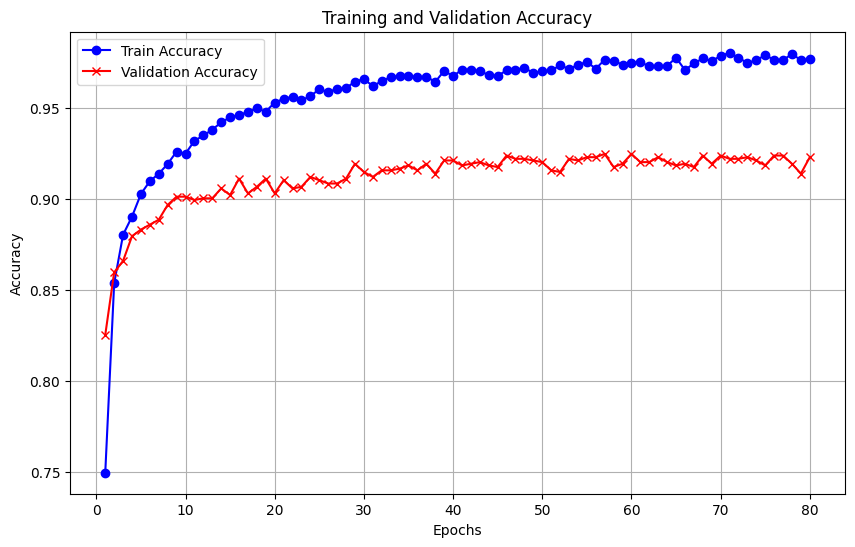

Test evaluation:
Confusion matrix:
 [[260  35   2   2]
 [ 10 266  13  13]
 [  0   3 306   0]
 [  5  13   0 277]]
Accuracy: 0.9203319502074688
F1 score: 0.9201461463584174


(0.9203319502074688, 0.9201461463584174)

In [30]:
# DENSENET pretrained ON RADIMAGENET, feature extraction with the pretrained model + finetuning the final fully connected layer
# BEST MODEL WITHOUT DROPOUT

EPOCHS = 80

model = DenseNetClassifier(len(train_data_full.classes), weights=Weights.RIMN, dropout=0, train_densenet=False).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

train_accuracies, val_accuracies, best_val_accuracy = train(model, EPOCHS, train_loader, val_loader, optimizer, criterion, device)

plot_metrics(EPOCHS, train_accuracies, val_accuracies)

print('Test evaluation:')
evaluate(model, test_loader, device)